In [10]:
using ModelingToolkit,DifferentialEquations,Plots
using ModelingToolkit: D_nounits as D, t_nounits as t

First we build a model with its parameters, variables and the equation of motion. We can give these defaults and set parameters to equal other equations etc. 

In [11]:
@mtkmodel FOL begin
    @parameters begin
        τ 
    end
    @variables begin
        x(t)
        RHS(t)
    end
    @equations begin
        RHS ~ (1-x)/τ
        D(x) ~ RHS
    end
end

ModelingToolkit.Model{typeof(__FOL__), Dict{Symbol, Any}}(__FOL__, Dict{Symbol, Any}(:variables => Dict{Symbol, Dict{Symbol, Any}}(:RHS => Dict(:type => Real), :x => Dict(:type => Real)), :kwargs => Dict{Symbol, Dict}(:RHS => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real), :τ => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real), :x => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real)), :independent_variable => t, :parameters => Dict{Symbol, Dict{Symbol, Any}}(:τ => Dict(:type => Real)), :equations => Any["RHS ~ (1 - x) / τ", "RHS ~ (1 - x) / τ", "D(x) ~ RHS"]), false)

We build the model provide it with an array of pairs for initial starting values, a tuple of time ranges and the values of all parameters. Can use keywords to not worry about ordering.

In [12]:
@mtkbuild fol=FOL()
prob=ODEProblem(fol,[fol.x=>0.0],(0.0,10.0),[fol.τ=>3.0])
sol=solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 14-element Vector{Float64}:
  0.0
  9.999999999999999e-5
  0.0010999999999999998
  0.011099999999999997
  0.11109999999999996
  0.44196924781807967
  1.0112520758966859
  1.7621013896357889
  2.7411196006326954
  3.954782507222947
  5.435343082434807
  7.201735027334962
  9.291406745592692
 10.0
u: 14-element Vector{Vector{Float64}}:
 [0.0]
 [3.333277778395056e-5]
 [0.00036659945265974064]
 [0.0036931634343634343]
 [0.03635598665335361]
 [0.13698489268755668]
 [0.28615114066001374]
 [0.44421130189743585]
 [0.5989648996141732]
 [0.7323994349297617]
 [0.8366363895140377]
 [0.9093330812230745]
 [0.9548191028045532]
 [0.9643240555350271]

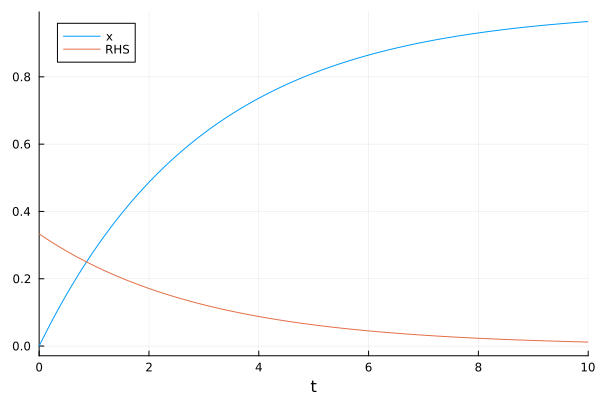

In [13]:
plot(sol,vars=[fol.x,fol.RHS])

Building Composite component-based hierarchical models

In [17]:
function fol_factory(seperate=false;name)
    @parameters τ
    @variables x(t) f(t) RHS(t)

    eqs = seperate ? 
        [RHS ~ (f-x)/τ ,D(x) ~ RHS] :
        D(x) ~ (f-x) / τ
    
    ODESystem(eqs,t;name)
end


fol_factory (generic function with 2 methods)

In [7]:
@named fol_1 = fol_factory()
@named fol_2 = fol_factory(true)


Model fol_2 with 2 equations
Unknowns (3):
  x(t)
  RHS(t)
  f(t)
Parameters (1):
  τ

In [8]:
connections = [fol_1.f ~ 1.5, fol_2.f ~fol_1.x]

connected=compose(ODESystem(connections,t,name=:connected),fol_1,fol_2)

Model connected with 5 equations
Unknowns (5):
  fol_1₊f(t)
  fol_2₊f(t)
  fol_1₊x(t)
  fol_2₊x(t)
⋮
Parameters (2):
  fol_1₊τ
  fol_2₊τ

In [9]:
connected_simp=structural_simplify(connected)

Model connected with 2 equations
Unknowns (2):
  fol_1₊x(t)
  fol_2₊x(t)
Parameters (2):
  fol_1₊τ
  fol_2₊τ
Incidence matrix:2×4 SparseArrays.SparseMatrixCSC{Num, Int64} with 5 stored entries:
 ×  ⋅  ×  ⋅
 ×  ×  ⋅  ×

In [10]:
full_equations(connected_simp)

2-element Vector{Equation}:
 Differential(t)(fol_1₊x(t)) ~ (1.5 - fol_1₊x(t)) / fol_1₊τ
 Differential(t)(fol_2₊x(t)) ~ (fol_1₊x(t) - fol_2₊x(t)) / fol_2₊τ

In [11]:
u0=[fol_1.x=>-0.5,fol_2.x=>1.0]
p=[fol_1.τ=>2.0,fol_2.τ=>4.0]

prob=ODEProblem(connected_simp,u0,(0.0,10.0),p)
sol=solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 12-element Vector{Float64}:
  0.0
  0.09301800173715992
  0.4217898006441298
  0.8907233774177459
  1.4080162937124434
  2.132773649049197
  2.960039864960882
  3.9744728401368814
  5.150477741173893
  6.543954679934549
  8.170597620470838
 10.0
u: 12-element Vector{Vector{Float64}}:
 [-0.5, 1.0]
 [-0.4091119373980162, 0.966577433165666]
 [-0.11971835953171236, 0.8699139536170639]
 [0.2188148958596286, 0.7802594756633092]
 [0.5108021431435599, 0.7310047127866949]
 [0.8114994919128119, 0.7216797288061625]
 [1.044733087795104, 0.7624939966991099]
 [1.225851130088202, 0.84856213510697]
 [1.3477262122941447, 0.9624565391464137]
 [1.4241330770687364, 1.0889674171898553]
 [1.4663577362029772, 1.2094301970843384]
 [1.4865176282524266, 1.3082692411088568]

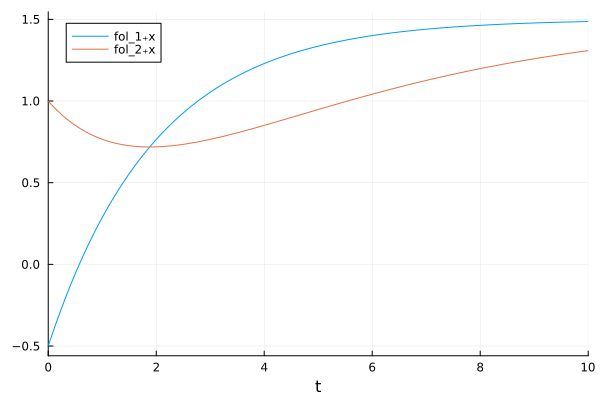

In [12]:
plot(sol)

How to add default values with either the @ method or the function method

In [18]:
@mtkmodel UnitstepFOLFactory begin
    @parameters begin
        τ = 1.0
    end
    @variables begin
        x(t) = 0.0
    end
    @equations begin
        D(x) ~ (1-x) / τ
    end
end

function UnitstepFOLFacttory_function(; name)
    @parameters τ
    @variables x(t)
    eqs = D(x) ~ (1-x) /τ
    ODESystem(eqs ; name, defaults=Dict(x=>0.0,τ=>1.0))
end


UnitstepFOLFacttory_function (generic function with 1 method)

In [16]:
@mtkbuild fol = UnitstepFOLFactory(; x = 0.1)
sol=ODEProblem(fol,[],(0.0,5.0),[]) |> solve

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 12-element Vector{Float64}:
 0.0
 0.0645677678571118
 0.23112586321494216
 0.47279997996782797
 0.7782099882421787
 1.168340018958489
 1.6418244200442873
 2.2128069066549645
 2.888015454160246
 3.6845362502170076
 4.6215123142148355
 5.0
u: 12-element Vector{Vector{Float64}}:
 [0.1]
 [0.15627467655510244]
 [0.285724385884508]
 [0.4390707362116239]
 [0.5866953750363533]
 [0.7202054759739022]
 [0.8257356363164883]
 [0.9015449468569201]
 [0.9498798747479449]
 [0.97739869398512]
 [0.9911413585329305]
 [0.9939327453112139]